# Datathon submission

In the following notebook we train a model for the [ECUSA AI + DATATHON SATURDAYS AI](https://www.ecusa.es/ecusa-ai-datathon-saturdays-ai/) challenge.

The algorithm of choice will be a neural network (NN), ultimately achieving **+87% accuracy on the entire dataset** (0 rows dropped) with little hyperparameter tunning. The goal and main reason to choose a NN for this problem will be to showcase a simple recipe to achieve very strong baselines for tabular data with little feature engineering.

To start, we will divide features in categorical, continuous or dates.

- For *categorical features* we will use learned embeddings. If we find missing values we won't do any imputation and just treat them as a separate class.
- For *numerical features* we just apply normalization. If there were any missing values, we would do a simple imputation (mean or median for example) AND we would create a binary feature to let the model know when the original value was missing and therefore the value passed imputed.
- *date features* are the only kind of feature for which we do more advanced feature engineering. We decompose them in their components (day, week, month, year) etc and turn some of these into categorical features and the rest into continuous. When appropriate, we will apply transformations to reflect the cyclical nature of some of these values (for example to reflect that January (month 1) comes after December (month 12)). You can check section [2.3.2](#232-encoding) for more details. Like for continuous values we will do simple imputations + additional feature to reflect when a date was missing. 

After all of this we will just concatenate all features and pass them through a couple of linear layers. Some more implementation details are discussed in sections [3.3](#33-build-model-preprocessing-layers) and [3.4](#34-concatenate-and-pass-through-linear-layers).

If you want to see a diagram of the model, jump to section [3.5](#35-compile-model-and-plot)!

We then just train this model for a few epochs with a simple optimizer with default hyperparameter, and that's it!

Finally, for a note on dangers of the train/test split strategy used for this challenge, check section [5.1](#51-traintest-split-for-time-series)

## 0. Imports

In [1]:
from enum import Enum
from pathlib import Path
from typing import Dict

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import  classification_report, confusion_matrix, ConfusionMatrixDisplay
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

from tqdm import tqdm

print(f"{tf.__version__ = }")
pd.set_option("display.max_columns", 500)

tf.__version__ = '2.6.1'


## 1. Inputs

In [2]:
# path to csv file
data_file_path = Path("data/COVID-19_Case_Surveillance_Public_Use_Data.csv")

# feature types
feature_type = Enum("feature_type", "categorical continuous date")

# target name
target_name = "death_yn"

# these are the initial features. This map will be updated
# as features are added or removed
feature_name=str
feature_to_type_map: Dict[feature_name, feature_type] = {
    "cdc_report_dt"                 : feature_type.date,
    "pos_spec_dt"                   : feature_type.date,
    "onset_dt"                      : feature_type.date,
    "current_status"                : feature_type.categorical,
    "sex"                           : feature_type.categorical,
    "age_group"                     : feature_type.categorical,
    "Race and ethnicity (combined)" : feature_type.categorical,
    "hosp_yn"                       : feature_type.categorical,
    "icu_yn"                        : feature_type.categorical,
    "medcond_yn"                    : feature_type.categorical,
}

## 2. Load and prep data

In [3]:
# load
df = pd.read_csv(data_file_path)
print(f"{df.shape = }")

/tmp/ipykernel_302295/243767048.py:2: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_file_path)


df.shape = (8405079, 11)


### 2.1 Prep target

In [4]:
# explore
cats = df[target_name].unique()
print(f"{cats = }")

# number of target classes
n_cats = len(cats)

# sanity check
assert not df[target_name].isna().any()

cats = array(['No', 'Missing', 'Unknown', 'Yes'], dtype=object)


In [5]:
# target encoding
targets = df[target_name]
target_encoder = LabelEncoder()
df[target_name] = target_encoder.fit_transform(targets)

### 2.2 Race or ethnicity

we apply the same preprocessing as in the original workshop

In [6]:
# copied from the original workshop notebook
aux = df.pop("Race and ethnicity (combined)").str.split(",", n=1, expand=True)
df["race"] = aux[0]
df["ethnicity"] = aux[1]

# update feature map
feature_to_type_map.pop("Race and ethnicity (combined)")
feature_to_type_map["race"] = feature_type.categorical
feature_to_type_map["ethnicity"] = feature_type.categorical

### 2.3 Prep Dates

#### 2.3.1 Imputation

In [7]:
def to_date(s: pd.Series, **kwargs) -> pd.Series:
    """Thin wrapper around pd.to_datetime to only return date portion
    """
    return pd.to_datetime(s, **kwargs).dt.date

In [8]:
# parse dates
cdc_report_dt = to_date(df["cdc_report_dt"])
pos_spec_dt = to_date(df["pos_spec_dt"])
onset_dt = to_date(df["onset_dt"])

In [9]:
cdc_report_dt.isna().any()

False

Since `cdc_report_dt` is always present, we can use it as a reference to impute the other 2 dates (which do have missing values)

In [10]:
# the fact that a date is missing can be a (binary) feature in inself
pos_spec_dt_is_missing = pos_spec_dt.isna()
onset_dt_is_missing = onset_dt.isna()

# str to make it consistent with every other categorical in this ds
df["pos_spec_dt_is_missing"]=np.where(pos_spec_dt_is_missing, "True", "False")
df["onset_dt_is_missing"]=np.where(onset_dt_is_missing, "True", "False")

feature_to_type_map["pos_spec_dt_is_missing"]=feature_type.categorical
feature_to_type_map["onset_dt_is_missing"]=feature_type.categorical

In [11]:
# compute median difference with cdc_report when date is not missing
# if we were being strict, we should compute the median with only samples from the training set
pos_spec_dt_median_diff = (pos_spec_dt[~pos_spec_dt_is_missing] - cdc_report_dt[~pos_spec_dt_is_missing]).median()
onset_dt_median_diff = (onset_dt[~onset_dt_is_missing] - cdc_report_dt[~onset_dt_is_missing]).median()

# impute cdc_report date + median difference
pos_spec_dt[pos_spec_dt_is_missing] = cdc_report_dt[pos_spec_dt_is_missing] + pos_spec_dt_median_diff
onset_dt[onset_dt_is_missing] = cdc_report_dt[onset_dt_is_missing] + onset_dt_median_diff

# sanity check: assert no missing values left
assert not pos_spec_dt.isna().any()
assert not onset_dt.isna().any()

/tmp/ipykernel_302295/3195476914.py:7: SettingWithCopyWarning: modifications to a property of a datetimelike object are not supported and are discarded. Change values on the original.
  pos_spec_dt[pos_spec_dt_is_missing] = cdc_report_dt[pos_spec_dt_is_missing] + pos_spec_dt_median_diff
/tmp/ipykernel_302295/3195476914.py:8: SettingWithCopyWarning: modifications to a property of a datetimelike object are not supported and are discarded. Change values on the original.
  onset_dt[onset_dt_is_missing] = cdc_report_dt[onset_dt_is_missing] + onset_dt_median_diff


In [12]:
# set all 3 back in df (as pd dates)
df["cdc_report_dt"] = cdc_report_dt
df["pos_spec_dt"] = pos_spec_dt
df["onset_dt"] = onset_dt

####  2.3.2 Encoding

In [13]:
def process_date_column(df: pd.DataFrame, column_name: str, feature_to_type_map: Dict) -> None:
    """
    Process date column in-place
    Modifies feature_to_type_map in-place as well to reflect new features
    """
    # pop column and transform it to datetime 
    date_column = pd.to_datetime(df.pop(column_name), errors='raise')
    _ = feature_to_type_map.pop(column_name)

    # decompose date
    date_column_year       = date_column.dt.year
    date_column_month      = date_column.dt.month
    date_column_week       = date_column.dt.isocalendar().week
    date_column_dayofmonth = date_column.dt.day
    date_column_dayofyear  = date_column.dt.dayofyear
    date_column_dayofweek  = date_column.dt.dayofweek #Monday=0, Sunday=6
    date_column_elapsed    = (date_column - date_column.min()).dt.days

    # encode cyclical features with sin/cos encoding
    def encode_cyclical(values: pd.Series, feature_name: str) -> None:
        """Encode cyclical 
        """
        df[f"{column_name}_{feature_name}_sin"] = np.sin(2 * np.pi * values / values.max())
        df[f"{column_name}_{feature_name}_cos"] = np.cos(2 * np.pi * values / values.max())

        feature_to_type_map[f"{column_name}_{feature_name}_sin"]=feature_type.continuous
        feature_to_type_map[f"{column_name}_{feature_name}_cos"]=feature_type.continuous

    encode_cyclical(date_column_month, feature_name="month")
    encode_cyclical(date_column_week, feature_name="week")
    encode_cyclical(date_column_dayofmonth, feature_name="dayofmonth")
    encode_cyclical(date_column_dayofyear, feature_name="dayofyear")
    encode_cyclical(date_column_dayofweek, feature_name="dayofweek")

    # in addition, add month and year as categorical
    # string to be consistent
    df[f"{column_name}_year"] = date_column_year.astype(str)
    df[f"{column_name}_month"] = date_column_month.astype(str)

    feature_to_type_map[f"{column_name}_year"]=feature_type.categorical
    feature_to_type_map[f"{column_name}_month"]=feature_type.categorical

    # and elapsed as continuous
    df[f"{column_name}_elapsed"] = date_column_elapsed
    feature_to_type_map[f"{column_name}_elapsed"]=feature_type.continuous


In [14]:
# Apply
date_features = [f for f,t in feature_to_type_map.items() if t == feature_type.date]
for f in date_features:
    process_date_column(df, column_name=f, feature_to_type_map=feature_to_type_map)

### 2.4 Set feature types

In [15]:
continuous_features = [f for f,t in feature_to_type_map.items() if t == feature_type.continuous]
categorical_features = [f for f,t in feature_to_type_map.items() if t == feature_type.categorical]

# sanity check
assert len(df.columns) == len(continuous_features) + len(categorical_features) + 1 

In [16]:
# continuous_features as float32
for f in continuous_features:
    assert not df[f].isna().any(), f"Na found in {f}"
    df[f]=df[f].astype(np.float32)

# categorical as categorical (older versions of pandas may not support this!)
for f in categorical_features:
    # NA will be just one more category
    df[f]=df[f].fillna("#NA#").astype("category")

    #sanity check
    assert not df[f].isna().any(), f"Na found in {f}"

### 2.5 show final

In [17]:
df.head()

,current_status,sex,age_group,hosp_yn,icu_yn,death_yn,medcond_yn,race,ethnicity,pos_spec_dt_is_missing,onset_dt_is_missing,cdc_report_dt_month_sin,cdc_report_dt_month_cos,cdc_report_dt_week_sin,cdc_report_dt_week_cos,cdc_report_dt_dayofmonth_sin,cdc_report_dt_dayofmonth_cos,cdc_report_dt_dayofyear_sin,cdc_report_dt_dayofyear_cos,cdc_report_dt_dayofweek_sin,cdc_report_dt_dayofweek_cos,cdc_report_dt_year,cdc_report_dt_month,cdc_report_dt_elapsed,pos_spec_dt_month_sin,pos_spec_dt_month_cos,pos_spec_dt_week_sin,pos_spec_dt_week_cos,pos_spec_dt_dayofmonth_sin,pos_spec_dt_dayofmonth_cos,pos_spec_dt_dayofyear_sin,pos_spec_dt_dayofyear_cos,pos_spec_dt_dayofweek_sin,pos_spec_dt_dayofweek_cos,pos_spec_dt_year,pos_spec_dt_month,pos_spec_dt_elapsed,onset_dt_month_sin,onset_dt_month_cos,onset_dt_week_sin,onset_dt_week_cos,onset_dt_dayofmonth_sin,onset_dt_dayofmonth_cos,onset_dt_dayofyear_sin,onset_dt_dayofyear_cos,onset_dt_dayofweek_sin,onset_dt_dayofweek_cos,onset_dt_year,onset_dt_month,onset_dt_elapsed
0,Laboratory-confirmed case,Male,10 - 19 Years,No,Unknown,1,No,Black,Non-Hispanic,False,True,-1.133108e-15,1.0,-1.332870e-01,0.991077,0.897805,-0.440394,-1.736482e-01,0.984808,8.660254e-01,0.5,2020,11,314.0,-0.5,0.866025,-0.375267,0.926917,0.897805,-0.440394,-0.758306,0.651899,0.866025,0.5,2020,11,316.0,-0.5,0.866025,-0.748511,0.663123,0.394356,0.918958,-0.789565,0.613667,0.000000,1.0,2020,11,313.0
1,Laboratory-confirmed case,Male,10 - 19 Years,No,No,1,No,Black,Non-Hispanic,False,False,-1.133108e-15,1.0,-1.332870e-01,0.991077,0.299363,-0.954139,-9.681087e-02,0.995303,-8.660254e-01,0.5,2020,11,318.0,-0.5,0.866025,-0.375267,0.926917,0.897805,-0.440394,-0.758306,0.651899,0.866025,0.5,2020,11,316.0,-0.5,0.866025,-0.663123,0.748511,0.897805,-0.440394,-0.696196,0.717852,0.866025,0.5,2020,11,321.0
2,Laboratory-confirmed case,Male,10 - 19 Years,No,No,1,No,Black,Non-Hispanic,False,False,-1.133108e-15,1.0,6.432490e-16,1.000000,-0.651372,-0.758758,-2.449294e-16,1.000000,1.224647e-16,-1.0,2020,11,323.0,-0.5,0.866025,-0.375267,0.926917,0.897805,-0.440394,-0.758306,0.651899,0.866025,0.5,2020,11,316.0,-0.5,0.866025,-0.663123,0.748511,0.968077,-0.250653,-0.708652,0.705558,0.000000,1.0,2020,11,320.0
3,Laboratory-confirmed case,Male,10 - 19 Years,Missing,Missing,1,Missing,Black,Non-Hispanic,False,True,-1.133108e-15,1.0,-1.332870e-01,0.991077,0.299363,-0.954139,-9.681087e-02,0.995303,-8.660254e-01,0.5,2020,11,318.0,-0.5,0.866025,-0.375267,0.926917,0.897805,-0.440394,-0.758306,0.651899,0.866025,0.5,2020,11,316.0,-0.5,0.866025,-0.748511,0.663123,0.937752,0.347305,-0.744704,0.667395,-0.866025,-0.5,2020,11,317.0
4,Laboratory-confirmed case,Male,10 - 19 Years,No,No,1,Yes,Black,Non-Hispanic,False,False,-1.133108e-15,1.0,-1.332870e-01,0.991077,0.485302,-0.874347,-1.160929e-01,0.993238,-8.660254e-01,-0.5,2020,11,317.0,-0.5,0.866025,-0.375267,0.926917,0.897805,-0.440394,-0.758306,0.651899,0.866025,0.5,2020,11,316.0,-0.5,0.866025,-0.663123,0.748511,0.897805,-0.440394,-0.696196,0.717852,0.866025,0.5,2020,11,321.0


## 3. Modeling

### 3.1 train/test split

In [18]:
train_df, valid_df = train_test_split(df, test_size=.33, random_state=42) # important note about this at the end

print(f"{len(train_df) = }")
print(f"{len(valid_df) = }")

len(train_df) = 5631402
len(valid_df) = 2773677


### 3.2 Define tf dataset

In [19]:
def df_to_dataset(dataframe: pd.DataFrame, target_name: str, shuffle: bool=True, batch_size: int=32):
  df = dataframe.copy()
  labels = df.pop(target_name)
  df_dict = {key: value.to_numpy()[:,None] for key, value in df.items()}
  ds = tf.data.Dataset.from_tensor_slices((df_dict, labels))
  if shuffle:
    # set max buffer size of 100k to avoid blowing up the memory
    # this may result in not perfect shuffles
    ds = ds.shuffle(buffer_size=min(len(dataframe), 100_00))
  ds = ds.batch(batch_size)
  ds = ds.prefetch(batch_size)
  return ds

In [21]:
# even on an older GPU like the one I'm using (K80)
# you can fit huge batch-sizes for tabular data
train_ds = df_to_dataset(train_df, batch_size=2048, target_name=target_name, shuffle=True)
valid_ds = df_to_dataset(valid_df, batch_size=2048, target_name=target_name, shuffle=False)

### 3.3 build model preprocessing layers

In [22]:
#helpers
def get_normalization_layer(name: str, dataframe: pd.DataFrame):
  """prep layer for continuous inputs
  """
  # I prefer computing these from pandas instead of calling
  # layer.adapt when I can get away with it because it's way faster
  mean = dataframe[name].mean()
  var = dataframe[name].var()
  
  # Create a Normalization layer for the feature.
  normalizer = layers.Normalization(axis=None, mean=mean, variance=var)

  return normalizer

def get_lookup_layer(name: str, dataframe: pd.DataFrame, max_tokens=None):
  """prep layer for categorical inputs (str->int)
  """
  # I prefer computing these from pandas instead of calling
  # layer.adapt when I can get away with it because it's way faster
  vocab = dataframe[name].unique()

  # create StringLookup layer for the feature
  string_lookup_layer = layers.StringLookup(vocabulary=vocab, max_tokens=max_tokens)

  return string_lookup_layer

def get_embedding_layer(vocab_size: int, size_multiplier=1):
  """learned dimensionality reduction layer for categorical inputs
  """
  def emb_sz_rule(n_cat:int)->int: 
    """
    fast-ais rule of thumb for embedding size
    https://github.com/fastai/fastai/blob/ed98cebf4a6e833729555a5311dbaa2d220ea8ee/fastai/tabular/model.py#L10
    """
    return min(600, round(1.6 * n_cat**0.56))
  
  output_size = size_multiplier * emb_sz_rule(vocab_size)
  embedding_layer = layers.Embedding(vocab_size, output_size)
  return embedding_layer

In [23]:
all_inputs = []
categorical_encoded = []
numerical_encoded = []

for f in tqdm(categorical_features):
    # define input
    # name is important! It needs to match the name of the feature in
    # the dict returned by the ds so Keras can map them
    # dtype is also important for stings or you'll get cryptic errors
    # when you launch the training
    feature_input = keras.Input(shape=(1,), name=f, dtype="string")
    all_inputs.append(feature_input)

    # add lookup+embedding layers
    # name is important! It needs to match the name of the feature in
    # the dict returned by the ds so Keras can map them
    lookup_layer = get_lookup_layer(f, train_df)
    embedding_layer = get_embedding_layer(vocab_size=lookup_layer.vocabulary_size())

    encoded_feature = embedding_layer(lookup_layer(feature_input))
    categorical_encoded.append(encoded_feature)

for f in tqdm(continuous_features):
    # define input
    feature_input = keras.Input(shape=(1,), name=f)
    all_inputs.append(feature_input)
    
    # add normalization layer
    normalization_layer = get_normalization_layer(f, train_df)
    encoded_feature = normalization_layer(feature_input)
    numerical_encoded.append(encoded_feature)


100%|██████████| 33/33 [00:01<00:00, 17.08it/s]


### 3.4 Concatenate and pass through linear layers

In [24]:
def apply_linear_bn_drop(x, linear_units, drop_p=.0, act='relu'):
    x = layers.Dense(linear_units, use_bias=False, activation=act)(x)
    x = layers.BatchNormalization()(x)
    if drop_p > 0: x = layers.Dropout(drop_p)(x)
    return x
    

In [25]:
# concatenate features
# concat returns tensor with shape (None, 1, sum(emb_sizes))
# we use lambda to remove dim1
cat_out = layers.Lambda(lambda x: x[:, 0, :])(layers.concatenate(categorical_encoded, axis=-1))

# add batchnorm to numerical 
bn_num_out = layers.BatchNormalization()(layers.concatenate(numerical_encoded, axis=-1))

# concat both
x = layers.concatenate([cat_out, bn_num_out])

# add a couple Linead/Act/Bn/DropOut blocks
x = apply_linear_bn_drop(x, linear_units=512)
x = apply_linear_bn_drop(x, linear_units=256)

# final layer
output = layers.Dense(n_cats)(x)

# define model
model = keras.Model(all_inputs, output)

### 3.5 Compile model and plot

In [26]:
model.compile(optimizer='rmsprop',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=["accuracy"])


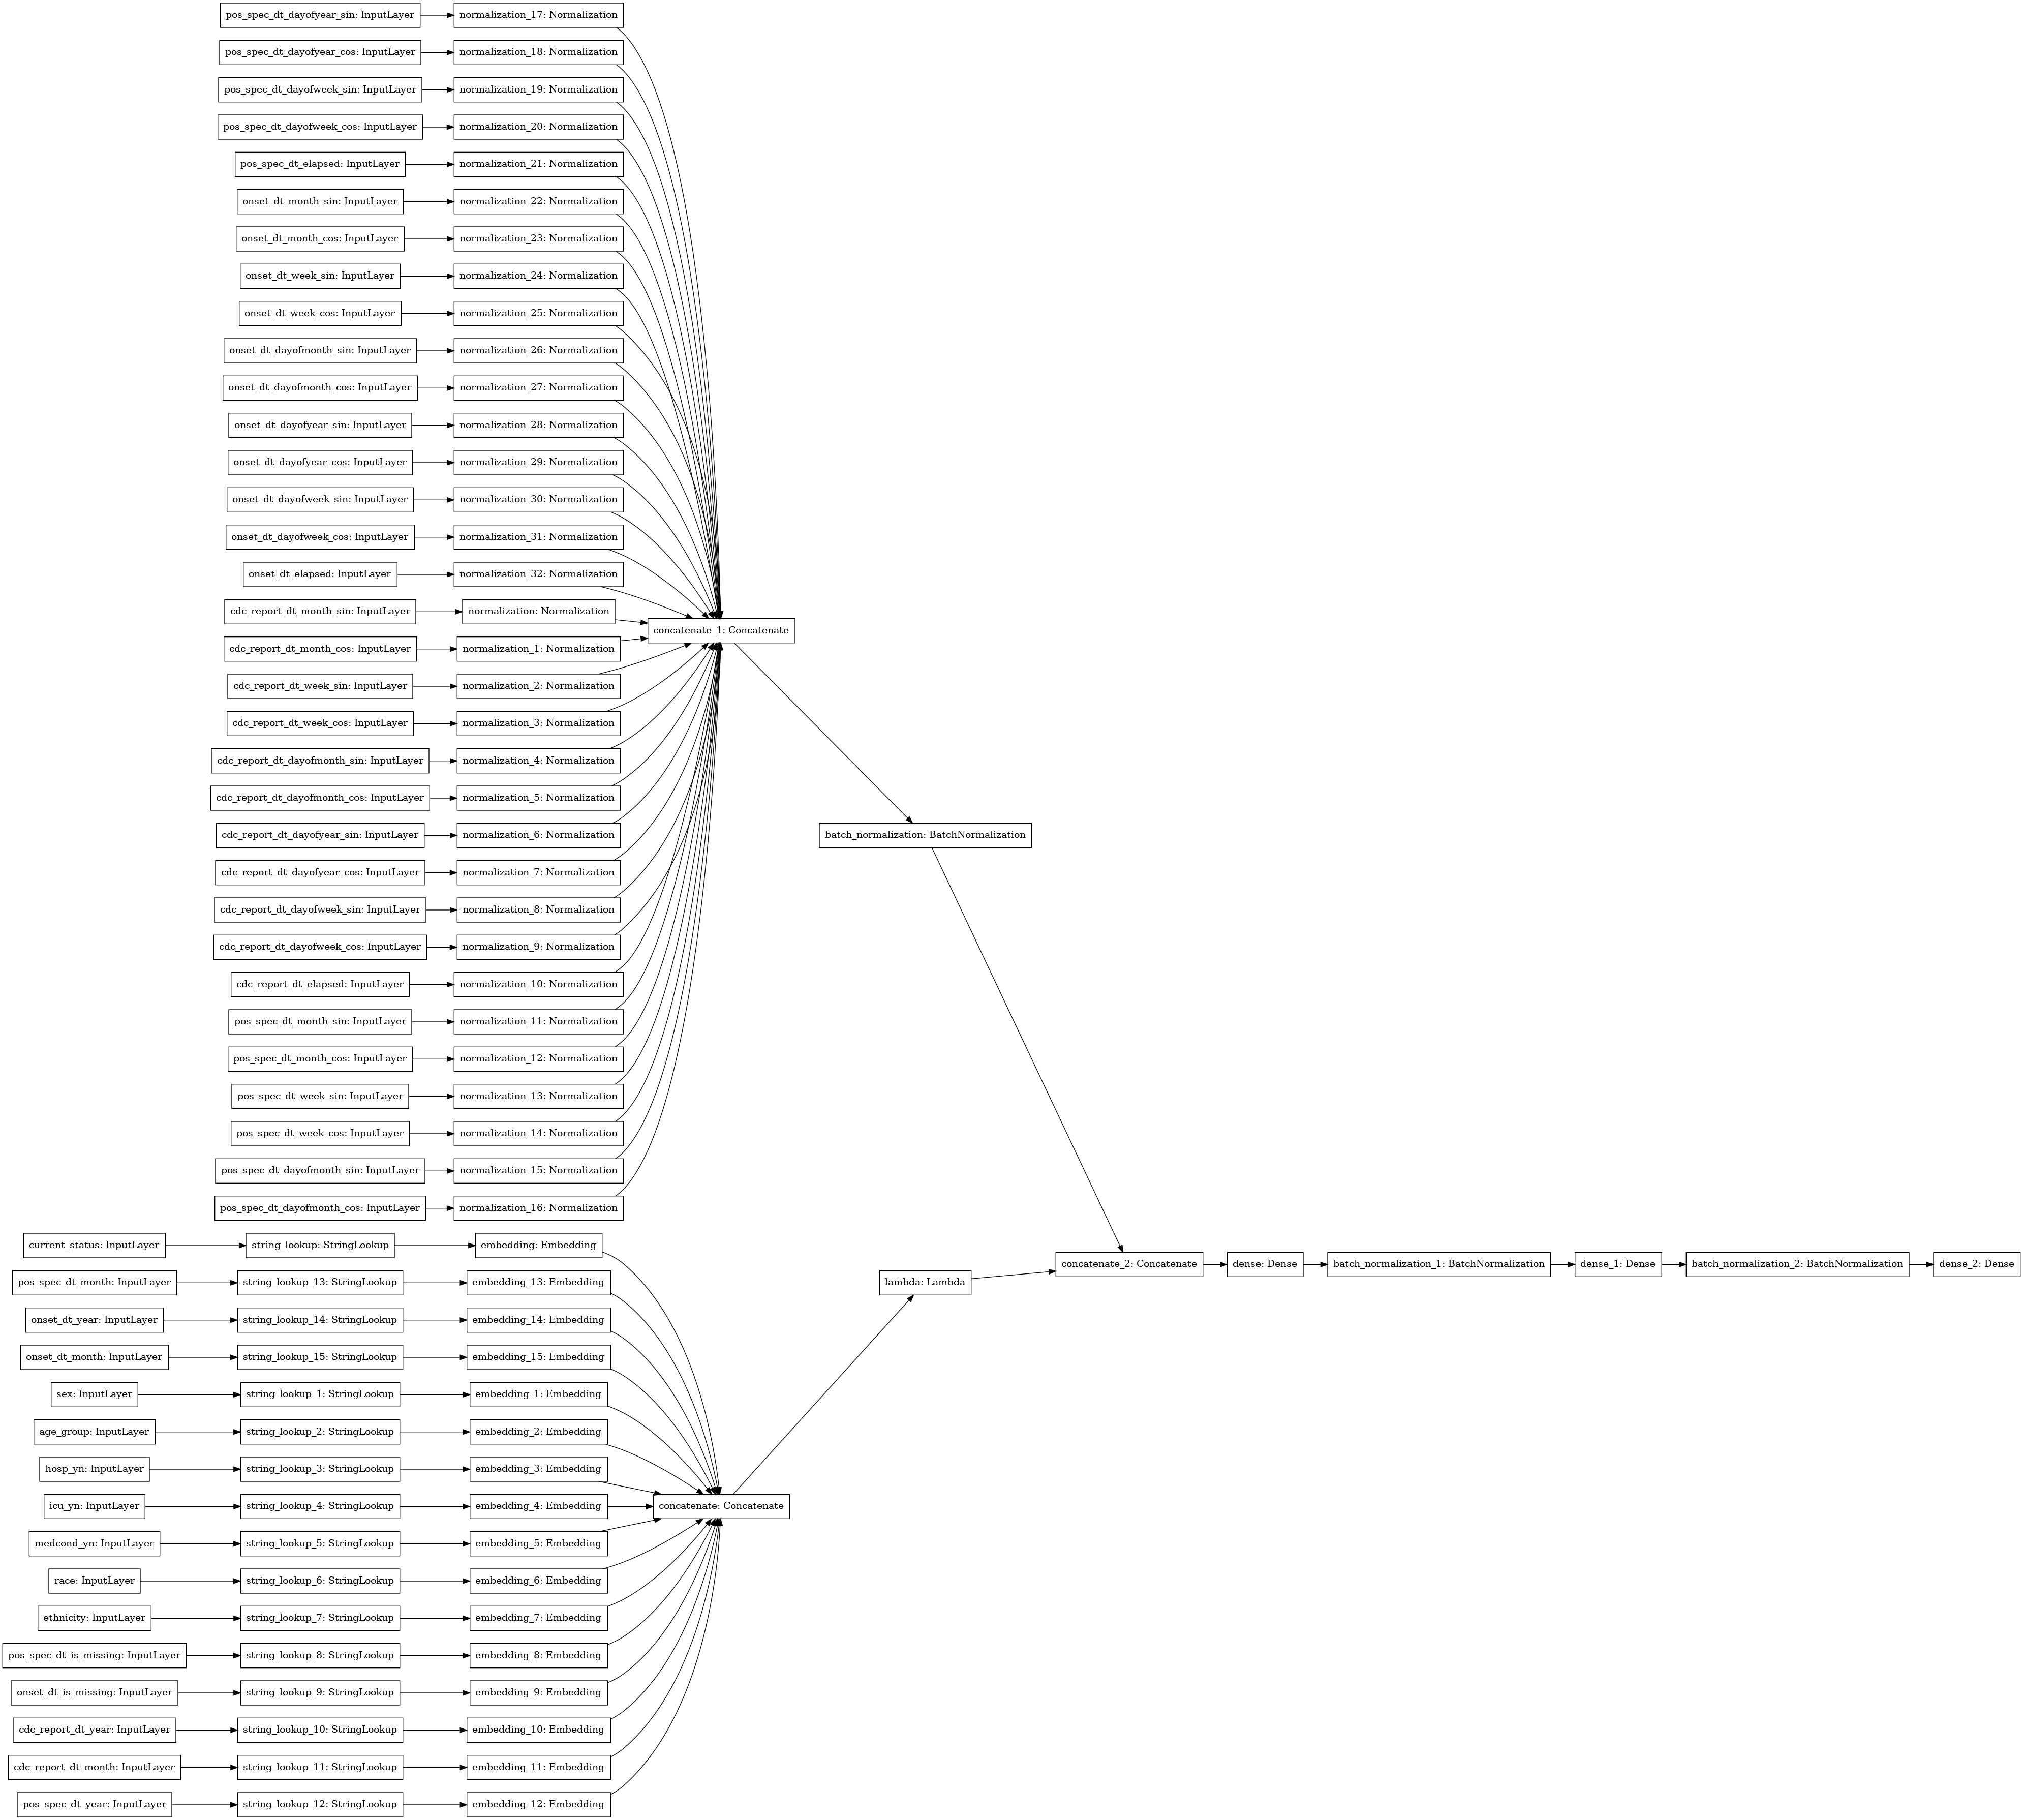

In [27]:
# Use `rankdir='LR'` to make the graph horizontal.
tf.keras.utils.plot_model(model, show_shapes=False, rankdir="LR")

### 3.6 Train!

In [28]:
history = model.fit(train_ds, epochs=4, validation_data=valid_ds)

Epoch 1/4


2022-04-05 01:15:20.869478: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


2750/2750 [==============================] - 476s 172ms/step - loss: 0.4129 - accuracy: 0.8541 - val_loss: 0.3705 - val_accuracy: 0.8679
Epoch 2/4
2750/2750 [==============================] - 471s 171ms/step - loss: 0.3623 - accuracy: 0.8704 - val_loss: 0.3580 - val_accuracy: 0.8718
Epoch 3/4
2750/2750 [==============================] - 472s 172ms/step - loss: 0.3548 - accuracy: 0.8726 - val_loss: 0.3561 - val_accuracy: 0.8724
Epoch 4/4
2750/2750 [==============================] - 475s 173ms/step - loss: 0.3508 - accuracy: 0.8739 - val_loss: 0.3528 - val_accuracy: 0.8734


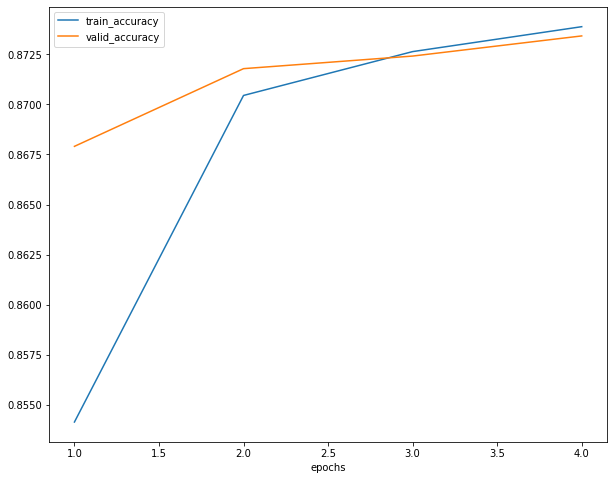

In [33]:
plt.figure(figsize=(10,8))

x = np.arange(4) + 1
plt.plot(x, history.history['accuracy'], label="train_accuracy")
plt.plot(x, history.history['val_accuracy'], label="valid_accuracy")

plt.xlabel("epochs")

plt.legend()
plt.show()

the model is still learning, so we could probably squeeze some more performance just by training it longer.

## 4. Evaluate

In [29]:
probas = model.predict(valid_ds)
predictions = probas.argmax(1)

In [30]:
print(classification_report(y_true=valid_df[target_name], y_pred=predictions, target_names=target_encoder.classes_, digits=4))

              precision    recall  f1-score   support

     Missing     0.8984    0.8996    0.8990   1150567
          No     0.8596    0.9007    0.8797   1218212
     Unknown     0.8650    0.7865    0.8239    344431
         Yes     0.6080    0.3206    0.4198     60467

    accuracy                         0.8734   2773677
   macro avg     0.8077    0.7268    0.7556   2773677
weighted avg     0.8709    0.8734    0.8707   2773677



final accuracy of **87.34%** on the validation set

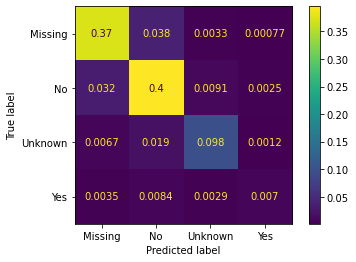

In [31]:
ConfusionMatrixDisplay.from_predictions(
    y_true=valid_df[target_name], 
    y_pred=predictions, 
    normalize='all', 
    display_labels=target_encoder.classes_
)

plt.show()

## 5. Others

### 5.1 Train/test split for time series

We follow the same train/test split as in the original workshop for a fair comparison. Please note that since we are working with time series data, for some use-cases this may not be appropriate. Check [this guide](https://scikit-learn.org/stable/modules/cross_validation.html#cross-validation-of-time-series-data) for more details and alternative sampling methods.